# Visualisation BART-CNN from Huggingface on the dataset CNN
* link1 : https://github.com/dhivyeshrk/FineTuning-Facebook-bart-large-cnn/blob/main/bart-large-cnn-finetune-for-textsummarization.ipynb
* link2 : https://huggingface.co/ainize/bart-base-cnn


In [2]:
import sys,os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch

from datasets import load_dataset
from datasets import load_from_disk

from rouge_score import rouge_scorer

from transformers import AutoTokenizer

In [ ]:

NUM_PROCS = os.cpu_count() 
NUM_LOADER = 8

print("NUM_PROCS = " ,NUM_PROCS)

MODEL_HUB = "facebook/bart-large-cnn"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'



max_len = 1024


BATCH_SIZE =2

NUM_BEAM = 5
max_len_resume = 200
repetition_penalty=2.0
length_penalty=1.0
early_stopping=True

NUM_PROCS =  12


In [ ]:
from transformers import AutoTokenizer, BartForConditionalGeneration

# Load Model and Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_HUB, clean_up_tokenization_spaces=True)
model = BartForConditionalGeneration.from_pretrained(MODEL_HUB)

print(model.config.max_position_embeddings) 


In [5]:
nb_params = 0 
for param in model.parameters():
    if param.requires_grad:
        nb_params += param.numel()

print(f"Total learnable parameters: {nb_params:_}")

memory_in_bytes = nb_params * 4  # 4 octet per parameter (32-bit floats)
#memory_in_gb = memory_in_bytes * 1e-9
param_size_gb = memory_in_bytes / (1024 ** 3)  # Convert bytes to gigabytes

print(f"Model parameters memory usage: {param_size_gb:.2f} GB")

Total learnable parameters: 406_290_432
Model parameters memory usage: 1.51 GB


In [6]:
print(tokenizer.vocab_size)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.bos_token, tokenizer.bos_token_id)
print(tokenizer.eos_token,tokenizer.eos_token_id)
print(tokenizer.unk_token,tokenizer.unk_token_id)
print(tokenizer.model_max_length)
tokenizer

50265
<pad> 1
<s> 0
</s> 2
<unk> 3
1000000000000000019884624838656


BartTokenizerFast(name_or_path='facebook/bart-large-cnn', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}

# Load the dataset and analyse some sample 

In [ ]:
# Load dataset (e.g., CNN/DailyMail)
#dataset = load_dataset("cnn_dailymail", "3.0.0", split='train')
# Load the saved dataset
dataset = load_from_disk('data/cnn_dailymail')


In [8]:
from IPython.display import display, HTML

def sample(dataset,nb_elt=1):
    assert nb_elt <= dataset.__len__()
    idx = np.random.choice(dataset.__len__(),nb_elt,replace=False)
    df_sample = dataset.select(idx).to_pandas().to_html()

    display(HTML(df_sample))


sample(dataset,3)


In [10]:
text =  dataset.select(np.random.choice(len(dataset),1)).to_pandas().article.values[0]
print(text)


#print(tokenizer)

print(tokenizer.tokenize(text))

source = tokenizer(text,return_tensors='pt')

print(source["input_ids"].squeeze(),source["attention_mask"].squeeze()) # .squeeze() to keel the batch dim 

tokenizer.decode(tokenizer("stockpiles .\nVenezuelan")["input_ids"])


For anyone who has marvelled  at the ease with which the Duchess of Cambridge has taken up her  royal role, it seems the skill simply runs in the family. Her mother Carole Middleton appeared happy and relaxed as she laughed and talked with the Duke of Edinburgh at Royal Ascot yesterday. The pair looked entirely comfortable in each other's company, sharing a joke and swapping observations as they watched the action from the royal balcony. Royal procession: The Queen and Prince Philip were accompanied in the first . carriage by Sir Peter O'Sullivan, 94, a BBC racing commentator, while the Middletons followed behind in the fourth carriage . Big day: The Middletons' appearance at Royal Ascot is a clear sign of their acceptance into the inner circle of the Royal Family . Good relations: The Duke of Edinburgh and Carole Middleton share a joke . whilst watching the Queen present the prize for the Gold Cup . All smiles: Carole was clearly tickled by what Prince Philip had to say . Ooh I say! E

# Know the length distribution of articles an highlights

In [ ]:
def len_distrib(batch):

    len_articles = []
    len_highlights = []
    
    # Prefix the "summarize: " instruction to each article (can be adjusted depending on your task)
    batch["article"] = ["summarize: " + article for article in batch["article"]]

    for article, highlight in zip(batch["article"], batch["highlights"]):
        len_articles.append(len(tokenizer(article, truncation=False)["input_ids"]))
        len_highlights.append(len(tokenizer(highlight, truncation=False)["input_ids"]))


    source = tokenizer(batch["article"],truncation=True, max_length=tokenizer.model_max_length)
    resume = tokenizer(batch["highlights"],truncation=True, max_length=tokenizer.model_max_length)

    return {
        'input_ids': source['input_ids'], 
        'input_mask': source['attention_mask'],
        'input_len': len_articles,
        'target_ids': resume['input_ids'], 
        'target_mask': resume['attention_mask'],
        'target_len': len_highlights
        }



# dataset = dataset.map(len_distrib,num_proc=NUM_PROCS,batched=True,batch_size=32)# Save the Hugging Face dataset
# dataset.save_to_disk('data/cnn_dailymail')
# print("Dataset saved successfully.")


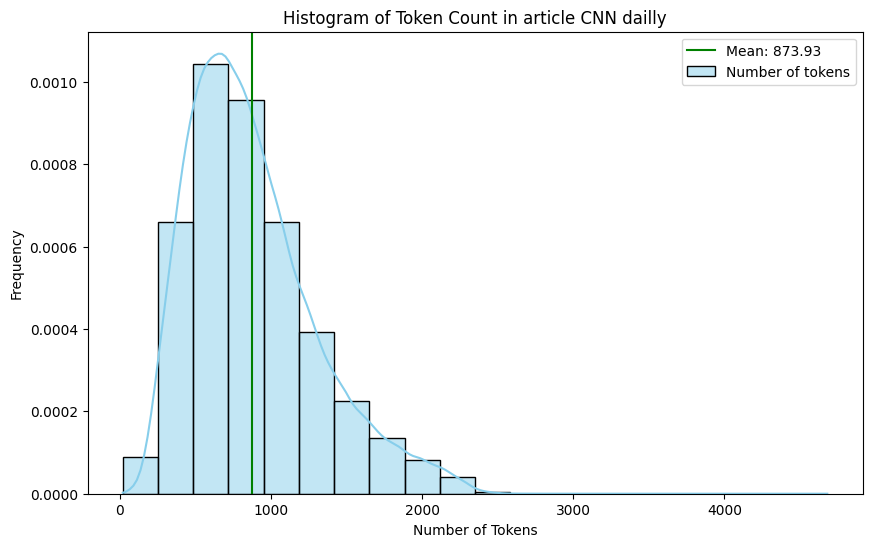

0.00% of texts have more than 1000000000000000019884624838656 tokens
max len  input_len    4681
dtype: int64


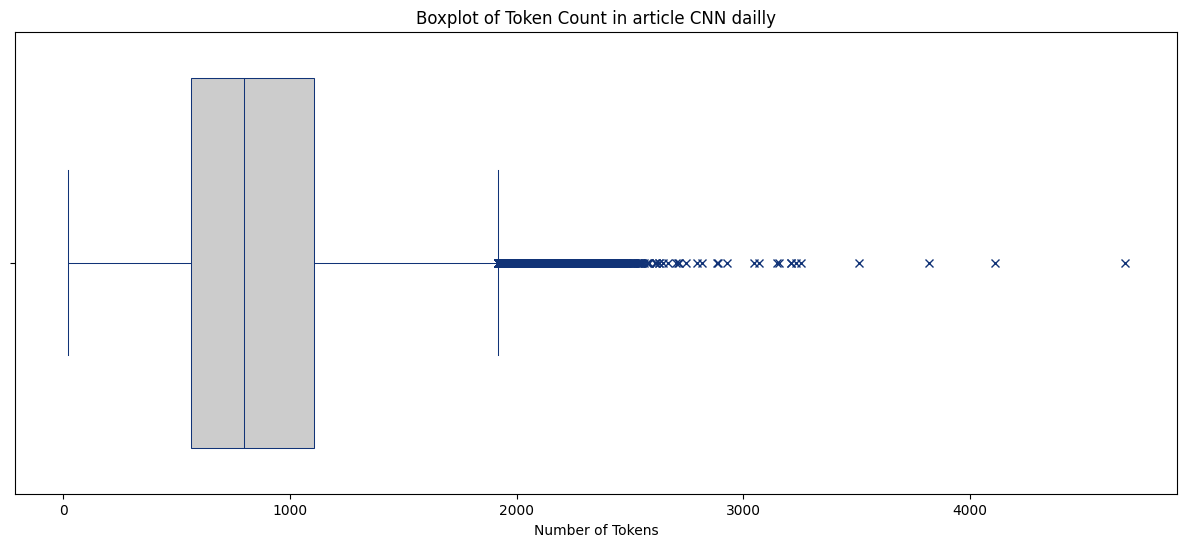

In [12]:

# Load input lengths into a DataFrame
article_inputs = pd.DataFrame({"input_len": dataset["input_len"]})

# Create the Seaborn histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=article_inputs, x="input_len", bins=20, kde=True, color='skyblue', label='Number of tokens',stat="density")

# Calculate mean length
mean_length = article_inputs["input_len"].mean()

# Add vertical lines for max token and mean token length
#plt.axvline(x=tokenizer.model_max_length, color='r', linestyle='--', label=f'Max token: {tokenizer.model_max_length}')
plt.axvline(x=mean_length, color='g', linestyle='-', label=f'Mean: {mean_length:.2f}')

# Add title, labels, and legend
plt.title('Histogram of Token Count in article CNN dailly')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()

# Calculate and display the percentage of texts with more than 512 tokens
percentage_over = (article_inputs[article_inputs["input_len"] > tokenizer.model_max_length].count() / article_inputs.count()) * 100
print(f"{percentage_over['input_len']:.2f}% of texts have more than {tokenizer.model_max_length} tokens")
print("max len ", article_inputs.max())

# Create the Seaborn histogram
plt.figure(figsize=(15, 6))
sns.boxplot(data=article_inputs, x="input_len", showcaps=True,
    flierprops={"marker": "x"},
     color=".8", linecolor="#137", linewidth=.75)


# Add title, labels, and legend
plt.title('Boxplot of Token Count in article CNN dailly')
plt.xlabel('Number of Tokens')

# Display the plot
plt.show()

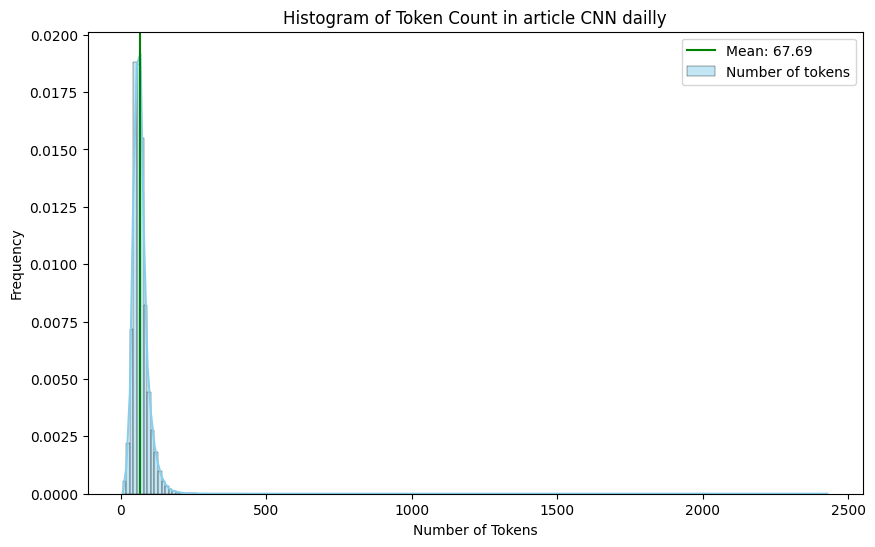

0.00% of texts have more than 1_000_000_000_000_000_019_884_624_838_656 tokens
max len  target_len    2428
dtype: int64


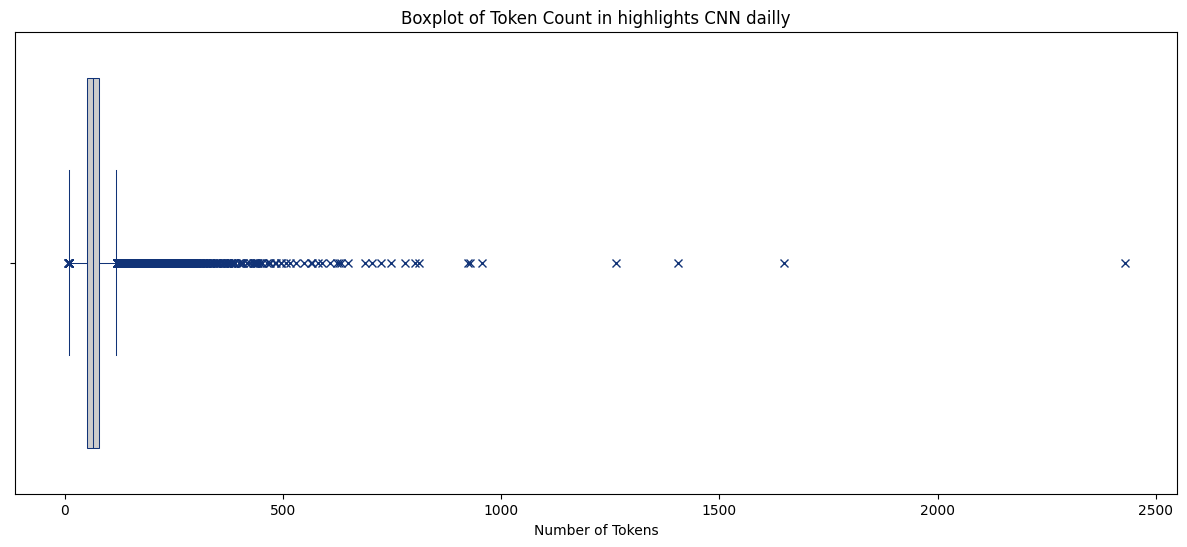

In [15]:

# Load input lengths into a DataFrame
target_inputs = pd.DataFrame({"target_len": dataset["target_len"]})

# Create the Seaborn histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=target_inputs, x="target_len", bins=200, kde=True, color='skyblue', label='Number of tokens',stat="density")

# Calculate mean length
mean_length = target_inputs["target_len"].mean()

# Add vertical lines for max token and mean token length
#plt.axvline(x=tokenizer.model_max_length, color='r', linestyle='--', label=f'Max token: {tokenizer.model_max_length}')
plt.axvline(x=mean_length, color='g', linestyle='-', label=f'Mean: {mean_length:.2f}')

# Add title, labels, and legend
plt.title('Histogram of Token Count in article CNN dailly')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()

# Calculate and display the percentage of texts with more than max_tokens
percentage_over = (target_inputs[target_inputs["target_len"] > tokenizer.model_max_length].count() / target_inputs.count()) * 100
print(f"{percentage_over['target_len']:.2f}% of texts have more than {tokenizer.model_max_length:_} tokens")
print("max len ", target_inputs.max())

# Create the Seaborn histogram
plt.figure(figsize=(15, 6))
sns.boxplot(data=target_inputs, x="target_len", showcaps=True,
    flierprops={"marker": "x"},
     color=".8", linecolor="#137", linewidth=.75)


# Add title, labels, and legend
plt.title('Boxplot of Token Count in highlights CNN dailly')
plt.xlabel('Number of Tokens')

# Display the plot
plt.show()


# model weight visualisation 

## PCA on the embeddings layer 

In [16]:
from sklearn.decomposition import PCA
import plotly.express as px

# Get the embedding layer
embedding_layer = model.get_input_embeddings().weight.detach().cpu().numpy()

# Apply PCA (reduce to 3 dimensions)
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embedding_layer)

# Create a DataFrame for easy plotting with token indices
embedding_df = pd.DataFrame({
    "PCA1": reduced_embeddings[:, 0],
    "PCA2": reduced_embeddings[:, 1],
    "PCA3": reduced_embeddings[:, 2],
    "Token Index": list(tokenizer.get_vocab().values())[:-1]  # Associate each point with a token index execpte the <MASK> token 
})

# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(
    embedding_df,
    x="PCA1", y="PCA2", z="PCA3",
    color="PCA1",  # Optional: color based on one component
    hover_data={"Token Index": True},  # Show token index on hover
    title="3D PCA of BART-large-CNN Embedding Table",
    opacity=0.7,
    height=800
)

# Show the plot with zooming enabled
fig.update_traces(marker=dict(size=5))  # Adjust marker size for better visibility
fig.show()


## attention_weights distribution

In [24]:
weight_attention = np.array([])
for name, param in model.named_parameters():
    if param.requires_grad and "attn" in name and "weight" in name:
        print(name)
        weight_attention = np.concatenate([weight_attention,param.clone().detach().cpu().numpy().flatten()])



model.encoder.layers.0.self_attn.k_proj.weight
model.encoder.layers.0.self_attn.v_proj.weight
model.encoder.layers.0.self_attn.q_proj.weight
model.encoder.layers.0.self_attn.out_proj.weight
model.encoder.layers.0.self_attn_layer_norm.weight
model.encoder.layers.1.self_attn.k_proj.weight
model.encoder.layers.1.self_attn.v_proj.weight
model.encoder.layers.1.self_attn.q_proj.weight
model.encoder.layers.1.self_attn.out_proj.weight
model.encoder.layers.1.self_attn_layer_norm.weight
model.encoder.layers.2.self_attn.k_proj.weight
model.encoder.layers.2.self_attn.v_proj.weight
model.encoder.layers.2.self_attn.q_proj.weight
model.encoder.layers.2.self_attn.out_proj.weight
model.encoder.layers.2.self_attn_layer_norm.weight
model.encoder.layers.3.self_attn.k_proj.weight
model.encoder.layers.3.self_attn.v_proj.weight
model.encoder.layers.3.self_attn.q_proj.weight
model.encoder.layers.3.self_attn.out_proj.weight
model.encoder.layers.3.self_attn_layer_norm.weight
model.encoder.layers.4.self_attn.k_p

In [25]:
# Global statistics
print(f"Global mean: {weight_attention.mean():.6f}")
print(f"Global std: {weight_attention.std():.6f}")
print(f"Global min: {weight_attention.min():.6f}")
print(f"Global max: {weight_attention.max():.6f}")

Global mean: 0.000133
Global std: 0.070183
Global min: -3.763672
Global max: 6.710938


In [26]:
weight_no_attention = np.array([])
for name, param in model.named_parameters():
    if param.requires_grad and (not "attn" in name) and (not "embed" in name) and "weight" in name:
        print(name)
        weight_no_attention = np.concatenate([weight_no_attention,param.clone().detach().cpu().numpy().flatten()])



model.shared.weight
model.encoder.layers.0.fc1.weight
model.encoder.layers.0.fc2.weight
model.encoder.layers.0.final_layer_norm.weight
model.encoder.layers.1.fc1.weight
model.encoder.layers.1.fc2.weight
model.encoder.layers.1.final_layer_norm.weight
model.encoder.layers.2.fc1.weight
model.encoder.layers.2.fc2.weight
model.encoder.layers.2.final_layer_norm.weight
model.encoder.layers.3.fc1.weight
model.encoder.layers.3.fc2.weight
model.encoder.layers.3.final_layer_norm.weight
model.encoder.layers.4.fc1.weight
model.encoder.layers.4.fc2.weight
model.encoder.layers.4.final_layer_norm.weight
model.encoder.layers.5.fc1.weight
model.encoder.layers.5.fc2.weight
model.encoder.layers.5.final_layer_norm.weight
model.encoder.layers.6.fc1.weight
model.encoder.layers.6.fc2.weight
model.encoder.layers.6.final_layer_norm.weight
model.encoder.layers.7.fc1.weight
model.encoder.layers.7.fc2.weight
model.encoder.layers.7.final_layer_norm.weight
model.encoder.layers.8.fc1.weight
model.encoder.layers.8.fc2

In [27]:
# Global statistics
print(f"Global mean: {weight_no_attention.mean():.6f}")
print(f"Global std: {weight_no_attention.std():.6f}")
print(f"Global min: {weight_no_attention.min():.6f}")
print(f"Global max: {weight_no_attention.max():.6f}")

Global mean: 0.000354
Global std: 0.056866
Global min: -21.609375
Global max: 23.093750


## ACP on the differente layers of the encoder bocks visualisation